In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 8]

import pandas as pd

sp500 = pd.read_csv("MULTPL-SP500_REAL_PRICE_MONTH.csv", parse_dates = ['Date'])
sp500 = sp500[sp500['Date'] >= '1920-01-01'].sort_values(by=['Date'])
max_index = sp500.index.max()
sp500.index = max_index - sp500.index

sp500["Date"] = pd.to_datetime(sp500["Date"])

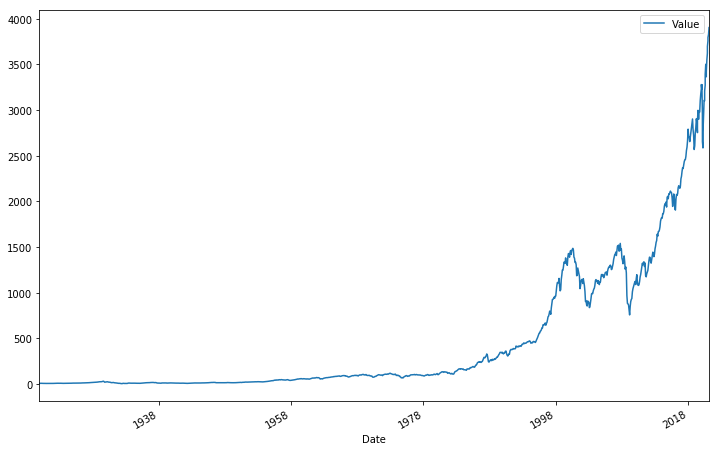

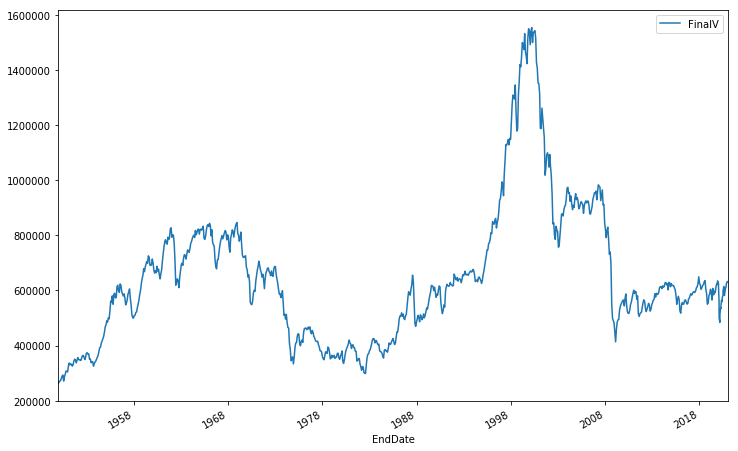

In [4]:
inv_years = 30
deposit_per_month = 500
def simulate(month_start):
    inv_hist = sp500[month_start: month_start+inv_years*12].copy()
    inv_hist['Units'] = deposit_per_month / inv_hist["Value"]
    inv_end_date = inv_hist['Date'].iat[-1]
    final_unit_value = inv_hist['Units'].sum() * inv_hist["Value"].iat[-1]
    return final_unit_value, inv_end_date

inv_sim = sp500.index[:-inv_years*12].map(lambda month: simulate(month)).tolist()
x = pd.DataFrame(inv_sim, columns=['FinalV','EndDate'])
inv_sim = sp500.join(x)

inv_sim.plot(x='Date', y='Value')
inv_sim.plot(x='EndDate', y='FinalV')